# ITI distributions

In [4]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy import stats

from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/tmptzfqs337/cache.zip Bytes: 117593947


100%|██████████| 112.1463270187378/112.1463270187378 [00:25<00:00,  4.40it/s]


## Load sessions

In [7]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)


List design matrices' eids

In [8]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [9]:
# Save data of all sessions for latter

session_all = defaultdict(list)

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = idxs[m][0:36]
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()

        # Save results per mouse
        mouse_name = idxs[m][37:]
        session_all[mouse_name] = {}
        session_all[mouse_name][session] = session_trials    
    
    else:
        print(mat)
            

lls_
_
_
_
_


In [88]:
def stack_trial_events(session_trials, trials_to_plot):
    # PLOT
    fig, axs = plt.subplots(nrows=trials_to_plot, ncols=1, sharex=True, sharey=True, figsize=[14, 12])
    plt.rc('font', size=12)
    y = [-1, 1]

    use_data = session_trials.reset_index()
    for t, trial in enumerate(range(trials_to_plot)):

        trial_start = use_data.loc[use_data['index']==t, 'intervals_0']
        next_trial = use_data.loc[use_data['index']==t+1]
        trial_data = use_data.loc[use_data['index']==t]
        trial_feedback = trial_data['feedbackType']

        axs[t].vlines(np.array(trial_data['stimOn_times']) - trial_start,
                        -1, 1, label='Stim On', color='Black')
        if list(trial_feedback)[0] == 1:
            axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                        -1, 1, label='Correct', color='Green', linewidth=2)
            axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                          list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='green', alpha=0.3)
            axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOff_times'])[0]-list(trial_start)[0], color='green', alpha=0.6)
        else:
            axs[t].vlines(np.array(trial_data['feedback_times']) - trial_start,
                        -1, 1, label='Incorrect', color='Red', linewidth=2)
            axs[t].fill_betweenx(y, list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], 
                          list(trial_data['feedback_times'])[0]-list(trial_start)[0], color='red', alpha=0.3)
            axs[t].fill_betweenx(y, list(trial_data['feedback_times'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOff_times'])[0]-list(trial_start)[0], color='red', alpha=0.6)
            
        axs[t].vlines(np.array(trial_data['firstMovement_times']) - trial_start, -1, 1, 
                        label='First movement', color='Blue')
        axs[t].vlines(np.array((trial_data['goCueTrigger_times'] - trial_data['quiescencePeriod'])) - trial_start,
                        -1, 1, label='Quiescence start', color='Purple')
        axs[t].vlines(np.array(trial_data['stimOff_times']) - trial_start,
                        -1, 1, label='Stim Off', color='Brown')
        axs[t].vlines(np.array(trial_data['intervals_1']) - trial_start,
                        -1, 1, label='Trial end', color='Orange')
        axs[t].vlines(np.array(next_trial['intervals_0']) - trial_start,
                        -1, 1, label='Next trial start', color='purple')  
        

        axs[t].fill_betweenx(y, 0, list(trial_data['goCueTrigger_times'] - 
                          trial_data['quiescencePeriod'])[0]-list(trial_start)[0], color='purple', alpha=0.6)
        axs[t].fill_betweenx(y, list(trial_data['goCueTrigger_times'] - 
                          trial_data['quiescencePeriod'])[0]-list(trial_start)[0], 
                          list(trial_data['stimOn_times'])[0]-list(trial_start)[0], color='purple', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['stimOn_times'])[0]-list(trial_start)[0],
                             list(trial_data['firstMovement_times'])[0]-list(trial_start)[0], color='blue', alpha=0.3)
        axs[t].fill_betweenx(y, list(trial_data['stimOff_times'])[0]-list(trial_start)[0],
                             list(trial_data['intervals_1'])[0]-list(trial_start)[0], color='orange', alpha=0.3)
    axs[t].set_yticks([] ,[])
    # axs[t].set_xticks([0, 9, 19] ,[-0.9, 0, 1])
    axs[t].set_xlabel(str('Time from go cue (s)'))
    axs[t].set_xlim([-.1, 10])

    axs[t].legend(loc='upper left', bbox_to_anchor=(1, -0.5))
    plt.show()

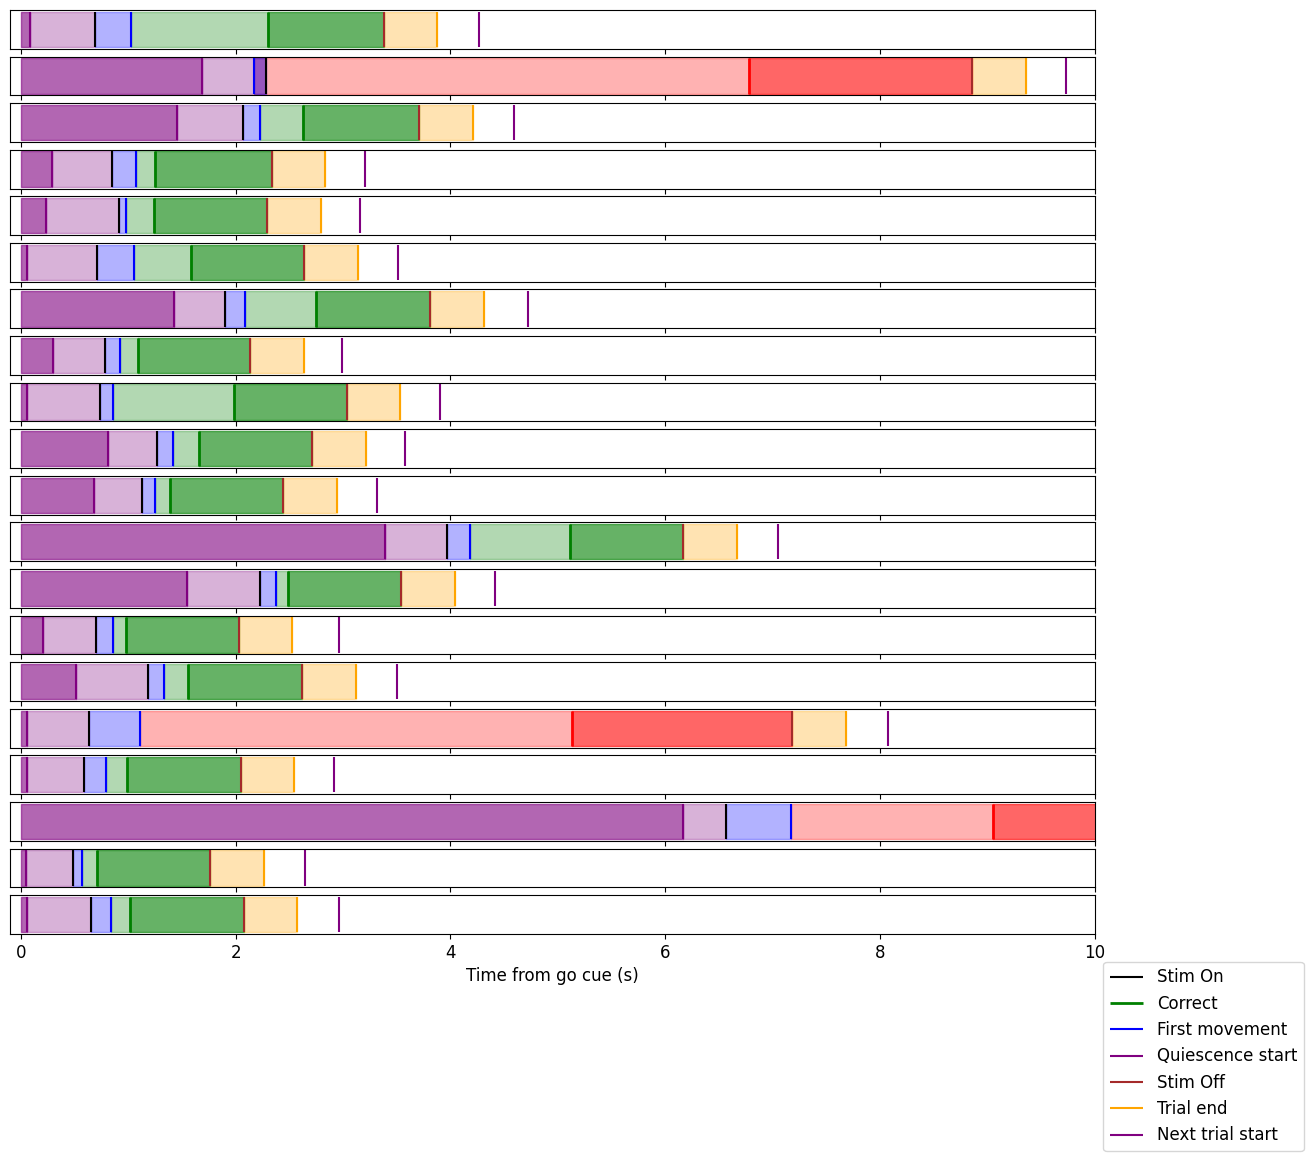

In [89]:
trials_to_plot = 20
stack_trial_events(session_trials, trials_to_plot)

In [106]:
use_data = session_trials.copy()
use_data['ITI'] = use_data['intervals_1'] - use_data['stimOff_times']
use_data['feedback_time'] = use_data['stimOff_times'] - use_data['feedback_times']
use_data['response_time'] = use_data['feedback_times'] - use_data['firstMovement_times']
use_data['reaction_time'] = use_data['firstMovement_times'] - use_data['goCueTrigger_times']
use_data['failing_quiescence'] = use_data['goCueTrigger_times'] - use_data['quiescencePeriod'] - use_data['intervals_0']
use_data['full_ITI'] = use_data['ITI']*np.NaN
use_data['full_ITI'][:-1] = np.array(use_data['intervals_0'][1:]) - np.array(use_data['stimOff_times'][:-1])

(0.0, 2.0)

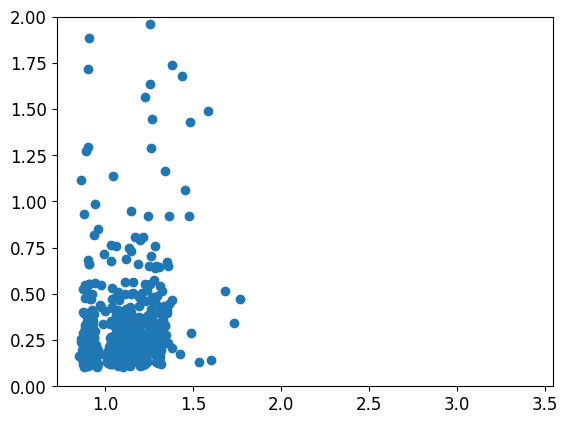

In [115]:
plt.scatter(use_data['full_ITI'], use_data['response_time'])
plt.ylim([0, 2])

(array([463.,  23.,  31.,  15.,   9.,   9.,   0.,   1.,   0.,   2.]),
 array([0.04549591, 0.65709359, 1.26869128, 1.88028896, 2.49188665,
        3.10348433, 3.71508202, 4.3266797 , 4.93827739, 5.54987507,
        6.16147276]),
 <BarContainer object of 10 artists>)

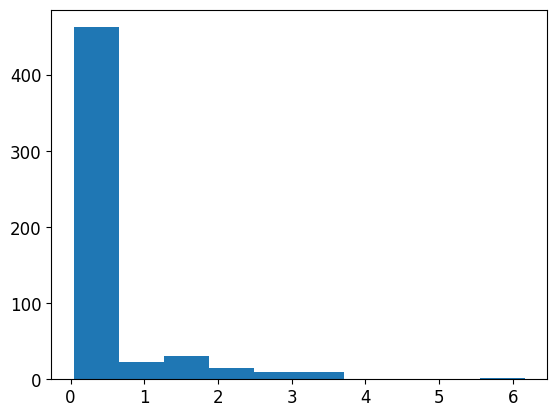

In [112]:
plt.hist(use_data['failing_quiescence'])

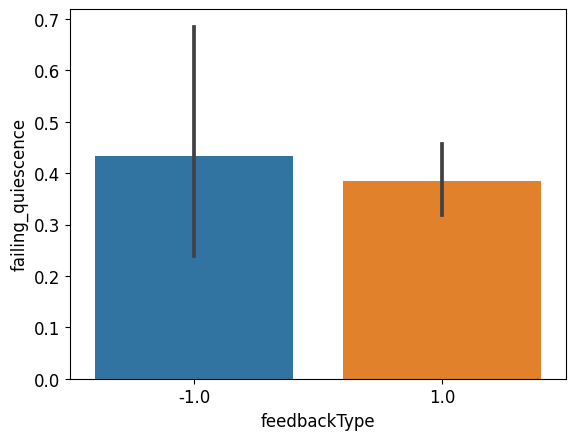

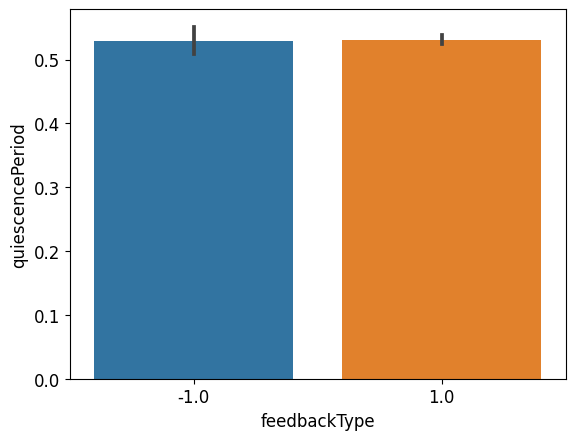

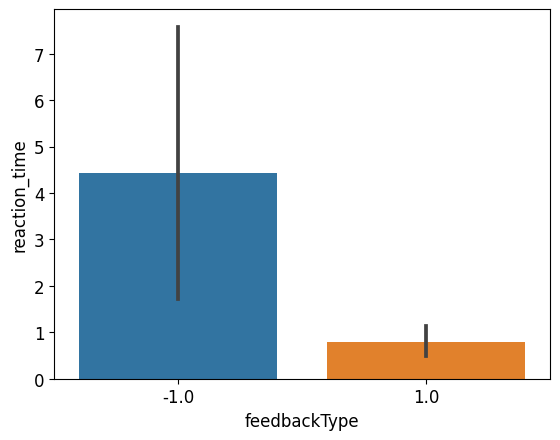

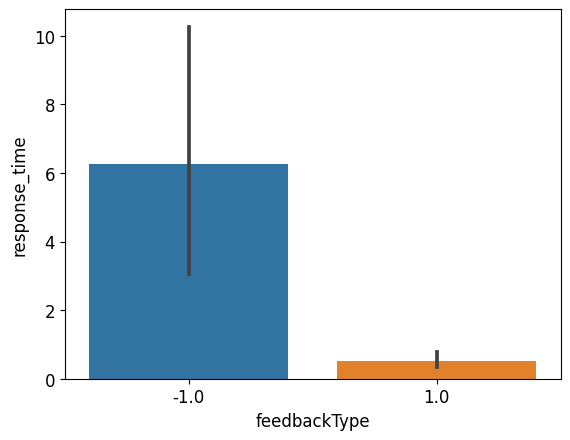

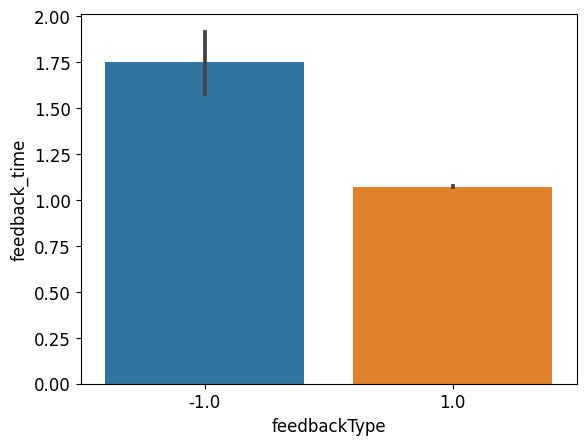

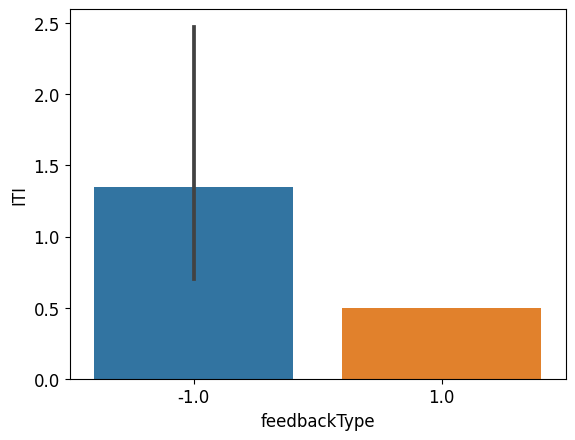

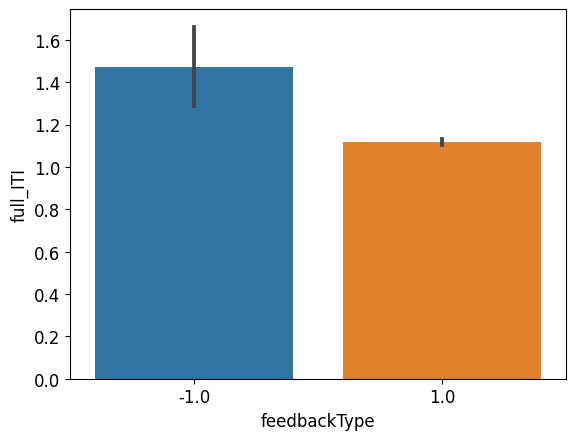

In [110]:
vars_interest = ['failing_quiescence', 'quiescencePeriod', 'reaction_time', 'response_time', 'feedback_time', 'ITI', 'full_ITI']

for var in vars_interest:
    # sns.histplot(x=var, hue='feedbackType', data=use_data)
    # plt.show()
    sns.barplot(x='feedbackType', y=var, data=use_data)
    plt.show()
    